 # Training a baseline MLP model

In [ ]:
import pandas as pd
import joblib
import torch, numpy as np
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    roc_auc_score,
)
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

 ## Data loading

In [ ]:
bundle = joblib.load("baseline_data_processing/data_payload_30s.pkl")

X_train = bundle["X_train"]
X_test = bundle["X_test"]
X_val = bundle["X_val"]

y_train = bundle["y_train"]
y_test = bundle["y_test"]
y_val = bundle["y_val"]

 ## DataLoader setup

In [ ]:
DEVICE = "cpu"
BATCH_SIZE = 256
EPOCHS = 25
LR = 1e-3  # will tune later


def make_loader(X, y, shuffle):
    tens_x = torch.tensor(X, dtype=torch.float32)
    tens_y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # (N,1) for BCE
    return DataLoader(
        TensorDataset(tens_x, tens_y),
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        drop_last=True,
    )


train_loader = make_loader(X_train, y_train, shuffle=True)
val_loader = make_loader(X_val, y_val, shuffle=False)
test_loader = make_loader(X_test, y_test, shuffle=False)

SEQ_LEN, N_FEATS = X_train.shape[1:]
FLAT_DIM = SEQ_LEN * N_FEATS

 ## Model Definition

 A simple three-layer perceptron that ingests the flattened window.

In [4]:
class MLPClassifier(nn.Module):
    def __init__(self, in_dim, hidden1=256, hidden2=64, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),  # (B, T, F) → (B, T*F)
            nn.Linear(in_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2, 1),  # binary logit
        )

    def forward(self, x):
        return self.net(x)


model = MLPClassifier(in_dim=FLAT_DIM).to(DEVICE)
print(model)

MLPClassifier(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=300, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=64, out_features=1, bias=True)
  )
)


 ## Training and validation loop

In [5]:
models_folder = "baseline_models/"

criterion = nn.BCEWithLogitsLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimiser, mode="min", factor=0.5, patience=2
)


def run_epoch(loader, train):
    total_loss, correct, total = 0.0, 0, 0
    model.train(train)
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        if train:
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

        preds = torch.sigmoid(logits) > 0.5
        correct += (preds.float() == yb).sum().item()
        total += yb.size(0)
        total_loss += loss.item() * yb.size(0)
    return total_loss / total, correct / total


best_val = 1e9
patience = 4
waited = 0

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    scheduler.step(va_loss)

    print(
        f"Epoch {epoch:02d} | "
        f"train: loss {tr_loss:.4f} acc {tr_acc:.3f} | "
        f"val: loss {va_loss:.4f} acc {va_acc:.3f}"
    )

    if va_loss < best_val:
        best_val, waited = va_loss, 0
        torch.save(model.state_dict(), models_folder + "best_mlp.pt")
    else:
        waited += 1
        if waited >= patience:
            print("Early stop.")
            break

Epoch 01 | train: loss 0.4103 acc 0.813 | val: loss 0.4482 acc 0.788
Epoch 02 | train: loss 0.3789 acc 0.826 | val: loss 0.4253 acc 0.785
Epoch 03 | train: loss 0.3633 acc 0.833 | val: loss 0.4341 acc 0.788
Epoch 04 | train: loss 0.3508 acc 0.839 | val: loss 0.4260 acc 0.788
Epoch 05 | train: loss 0.3416 acc 0.844 | val: loss 0.4510 acc 0.777
Epoch 06 | train: loss 0.3279 acc 0.850 | val: loss 0.4423 acc 0.787
Early stop.


 ## Test-set evaluation

In [6]:
all_pred, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb.to(DEVICE))
        all_pred.extend((torch.sigmoid(logits) > 0.5).cpu().numpy().ravel())
        all_true.extend(yb.numpy().ravel())

y_pred = np.array(all_pred, dtype=int)
y_true = np.array(all_true, dtype=int)

cm = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = cm.ravel()

acc = accuracy_score(y_true, y_pred)
recall = TP / (TP + FN + 1e-12)  # sensitivity / TPR
spec = TN / (TN + FP + 1e-12)  # specificity / TNR
prec = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Confusion matrix (rows: true, cols: pred)")
print(cm, "\n")
print(f"Accuracy     : {acc :.3f}")
print(f"Recall (TPR) : {recall :.3f}")
print(f"Specificity  : {spec :.3f}")
print(f"Precision    : {prec :.3f}")
print(f"F1-score     : {f1 :.3f}")

Confusion matrix (rows: true, cols: pred)
[[22327  5346]
 [ 4961  7558]] 

Accuracy     : 0.744
Recall (TPR) : 0.604
Specificity  : 0.807
Precision    : 0.586
F1-score     : 0.595


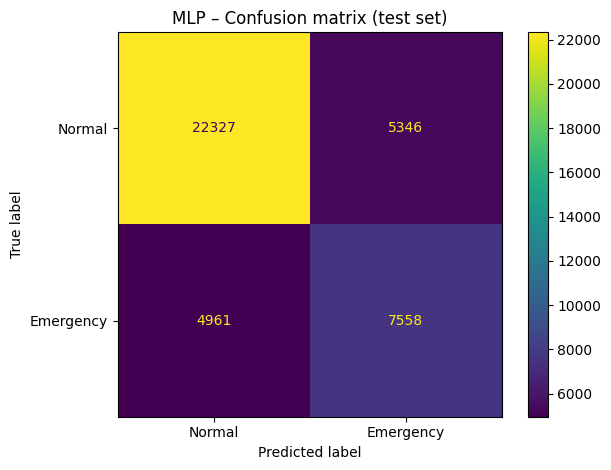

In [7]:
fig1, ax1 = plt.subplots()
ConfusionMatrixDisplay(cm, display_labels=["Normal", "Emergency"]).plot(ax=ax1)
ax1.set_title("MLP – Confusion matrix (test set)")
plt.tight_layout()
plt.show()

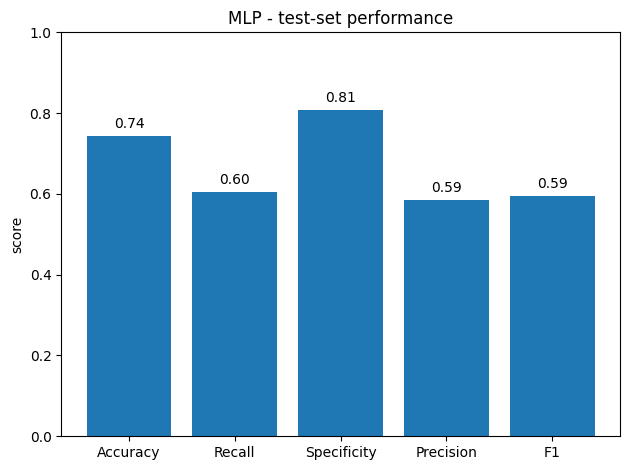

In [9]:
fig2, ax2 = plt.subplots()
metrics = [acc, recall, spec, prec, f1]
labels = ["Accuracy", "Recall", "Specificity", "Precision", "F1"]
ax2.bar(labels, metrics)
ax2.set_ylim(0, 1)
ax2.set_ylabel("score")
ax2.set_title("MLP - test-set performance")
for idx, v in enumerate(metrics):
    ax2.text(idx, v + 0.02, f"{v:.2f}", ha="center")
plt.tight_layout()
plt.show()